<a href="https://www.kaggle.com/code/sundeepkondaveeti/cancer-predictors-final-draft?scriptVersionId=237356861" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-cancer-patients-2015-2024/global_cancer_patients_2015_2024.csv


  Patient_ID  Age  Gender Country_Region  Year  Genetic_Risk  Air_Pollution  \
0  PT0000000   71    Male             UK  2021           6.4            2.8   
1  PT0000001   34    Male          China  2021           1.3            4.5   
2  PT0000002   80    Male       Pakistan  2023           7.4            7.9   
3  PT0000003   40    Male             UK  2015           1.7            2.9   
4  PT0000004   43  Female         Brazil  2017           5.1            2.8   
5  PT0000005   22    Male        Germany  2018           9.5            6.4   
6  PT0000006   41    Male         Canada  2021           5.1            8.2   
7  PT0000007   72  Female         Canada  2018           6.0            8.2   
8  PT0000008   21    Male            USA  2022           4.3            3.8   
9  PT0000009   49  Female         Canada  2016           8.1            0.8   

   Alcohol_Use  Smoking  Obesity_Level Cancer_Type Cancer_Stage  \
0          9.5      0.9            8.7        Lung    Stage III

/tmp/ipykernel_13/4055513113.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical[feature]= LabelEncoder().fit_transform(X_categorical[feature])
/tmp/ipykernel_13/4055513113.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical[feature]= LabelEncoder().fit_transform(X_categorical[feature])
/tmp/ipykernel_13/4055513113.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Info] Start training from score 4.953744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

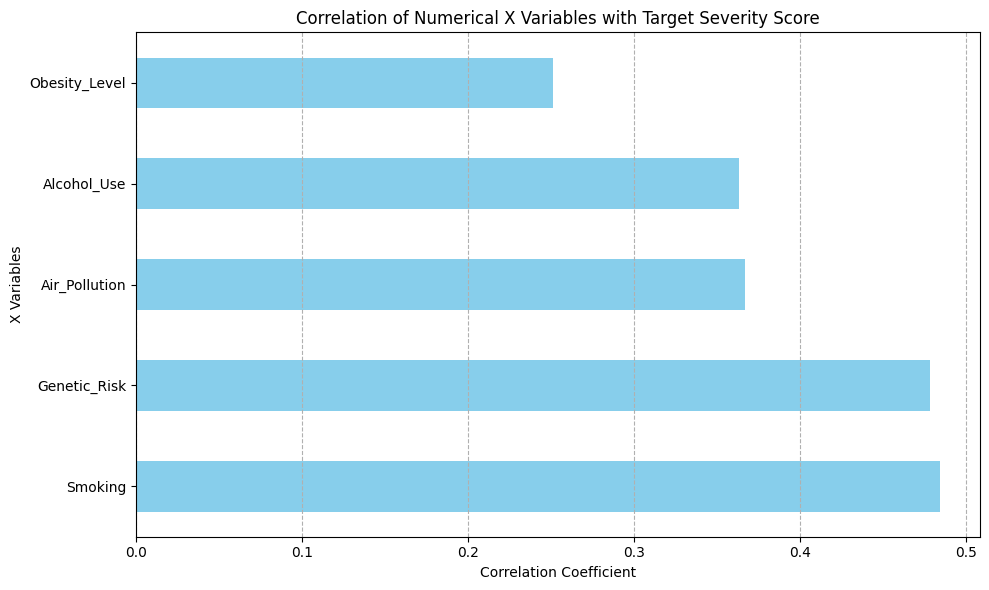

In [2]:
# 1. Import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Model evaluation critieria
import xgboost as xgb # Extreme Gradient Boost Model
import lightgbm as lgb # Light Gradient Boost Model
from catboost import CatBoostRegressor # Category Boost Model
from sklearn.preprocessing import LabelEncoder # For converting the categorical variables

# 2. Read the .csv file

df= pd.read_csv('/kaggle/input/global-cancer-patients-2015-2024/global_cancer_patients_2015_2024.csv')

print(df.head(10)) # print the top 10 rows

print(df.describe()) # summary statistics : mean, min, max, quartiles, std dev

# 3. Formulate the key hypotheses: 
# 1. Which of the factors contribute the most to Cancer (Target_Severity_Score) ?
# 2. What combination of factors give us the best accuracy of Cancer prediction ?



# 4. Define X and y variables

column_list= df.columns.tolist()
print(column_list)

# ['Patient_ID', 'Age', 'Gender', 'Country_Region', 'Year', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 
#  'Smoking', 'Obesity_Level', 'Cancer_Type', 'Cancer_Stage', 'Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']

X_numerical = df[['Age', 'Year','Genetic_Risk', 'Air_Pollution', 'Alcohol_Use','Smoking','Obesity_Level']]

X_categorical = df[['Country_Region','Gender']]

y = df[['Target_Severity_Score']]


# 5. Introduce categorical variables: Alcohol use (1/0) | Smoking (1/0) | Age groups/ Demographics (20-30|30-40|40-50|50+)

def category_age(age_series):
    age_group = []
    for age in age_series:
        if 20 <= age <= 30:
            age_group.append('20-30')
        elif 31 <= age <= 40:
            age_group.append('30-40')
        elif 41 <= age <= 50:
            age_group.append('40-50')
        elif 50 <= age:
            age_group.append('50+')
        else:
            age_group.append('other')
    return age_group

df['Age Group'] = category_age(df['Age'])

print(df.head(10))

X_numerical = df[['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use','Smoking','Obesity_Level']]

X_categorical = df[['Age Group','Country_Region','Gender']]

y = df[['Target_Severity_Score']]


# 6. Replace null values with mean for numerical variables so the distribution of the data is not changing. 

for col in df.select_dtypes(include=['number']).columns:
    df[col]= df[col].fillna(df[col].mean())

# 7. Replace null values with mean for categorical variables with a string: 'unknown'

for col in df.select_dtypes(include=['string']).columns:
    df[col]= df[col].fillna('unknown')

# 8. Separate X variables in to numerical and categorical variable

X_numerical = df[['Year','Genetic_Risk', 'Air_Pollution', 'Alcohol_Use','Smoking','Obesity_Level']]

X_categorical = df[['Age Group','Country_Region','Gender']]


# 9. Apply Label Encoding to the categorical variables

label_encoders = {} #initiation
for feature in X_categorical:
    X_categorical[feature]= LabelEncoder().fit_transform(X_categorical[feature])


# 10. Combine numerical and categorical variables

X= pd.concat([X_numerical, X_categorical], axis= 1)

# 11. Split the datasets in to train and test samples: 80% train | 20% test

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

# 12. Initiate and train the Extreme Gradient Boost Regressor model

xgb_model = xgb.XGBRegressor (objective= 'reg:squarederror', # train method
                             n_estimators= 100, # no. of iterations
                             max_depth = 3,
                             random_state=42)

xgb_model.fit(X_train,y_train)

    #Initiate and train the light Gradient Boost Regressor model

lgbm_model = lgb.LGBMRegressor(objective='regression_l2', # train method
                      n_estimators= 100, # no. of iterations
                      learning_rate= 0.1,
                      max_depth= 3,
                        random_state=42)
lgbm_model.fit(X_train,y_train)


     #Initiate and train the Cat Gradient Boost Regressor model

catboost_model = CatBoostRegressor(objective='RMSE', # train method
                        iterations= 100, # no. of iterations
                        learning_rate= 0.1,
                        depth= 3, # equivalent to max depth
                        random_seed=42, # equivalent to random state
                        verbose=0)
catboost_model.fit(X_train,y_train)


# 13. Model prediction on test sample

y_pred=lgbm_model.predict(X_test)

# 14.Model evaluation criteria

rmse= mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error:{rmse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error:{mae}")

r_squared = r2_score(y_test, y_pred)
print(f"R squared:{r_squared}")

# 15. Visualizing the correlation with the dependent X variables

X_numerical = df[['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level']]
y = df['Target_Severity_Score']

# Calculate the correlation of each X variable with y
correlations = X_numerical.corrwith(y).sort_values(ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
correlations.plot(kind='barh', color='skyblue')
plt.xlabel('Correlation Coefficient')
plt.ylabel('X Variables')
plt.title('Correlation of Numerical X Variables with Target Severity Score')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()